In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Monte Carlo Simulation

```{margin}
This lecture is based on _Probability and Statistics_ by _M. H. DeGroot and M.J. Schervish_, Chapter 11.
```

Today we will introduce Monte Carlo simulation. It is the final puzzle piece that we need for the Markov Chain Monte Carlo method. 

## Why is Simulation Useful?

_Simulation_ is a powerful technique used to understand how complex systems work, even when detailed analysis is not possible. 

For example, simulations allow data scientists to test and validate models under various scenarios without the need for real-world data, which can be costly or difficult to obtain. In addition, when real data is scarce, simulations can generate synthetic data that mimics real-world processes, which is useful for training machine learning models. 

Simulations help estimate features of models that __can not be computed analytically__. 

Simulations that rely on repeated random sampling are often called _Monte Carlo simulations_ (or _Monte Carlo analysis_), named after the famous European gambling center. 

<center>
    
<img src="images/Real_Monte_Carlo_Casino.jpg" width="450px">
    
</center>

<center>
Monte Carlo Casino, Monaco  
</center>

Monte Carlo simulation has three main classes of applications:
- optimization,
- numerical integration, and 
- generating draws from probability distributions.

The last class is the main reason for our interest in Monte Carlo analysis. We will combine it with our knowledge of Markov chains in the upcoming two lectures.

However, we will explain the main idea behind the Monte Carlo method by using it to compute an integral. 

Some integrals can be solved exactly using math (these are called __closed-form__ solutions). However, many integrals cannot be solved this way. Instead, we can use simulations to approximate the solutions.

Suppose we want to find the integral from 3 to 7 of 

$$f(x) = x^2.$$

That is, we want to compute the area under the curve of $x^2$ for $3 < x < 7.$

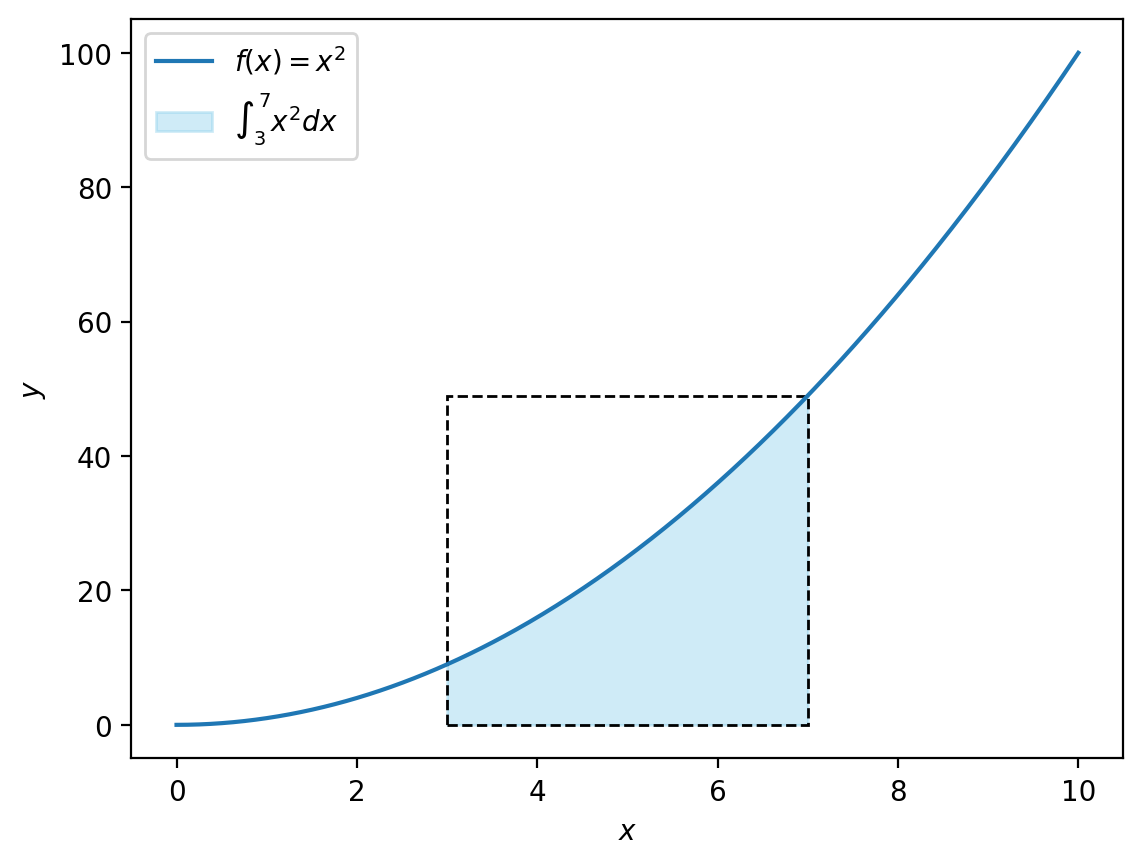

In [2]:
# Define x and y
x = np.linspace(0, 10, 400)
y = x**2

plt.plot(x, y, label='$f(x) = x^2$')

# Fill the area under the curve for 3 < x < 7
x_fill = np.linspace(3, 7, 200)
y_fill = x_fill**2
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.4, label='$\int_3^7 x^2 dx$')

# Add a rectangle from (3, 0) to (7, 49)
plt.gca().add_patch(plt.Rectangle((3, 0), 4, 49, edgecolor='black', facecolor='none', linestyle='--'))

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()


To estimate this area, we can draw random points inside a rectangle that contains it. Then, we count how many points fall under the curve of $x^2$. 

In [3]:
num_trials = 100000

# Generate random values for x and y
np.random.seed(42)

x = np.random.uniform(3, 7, num_trials)
y = np.random.uniform(0, 49, num_trials)

# Determine which y points are less than or equal to x^2
below_curve = y <= x**2
print('Out of', num_trials, 'trials,', np.sum(below_curve), 'points fall under the curve')

Out of 100000 trials, 53760 points fall under the curve


Now that we have our points, we can estimate the area under the curve. 

The idea is that the ratio of points below the curve to the total number of points is the same as the ratio of the area under $x^2$ to the total area of the rectangle. That is, 

$$\frac{\text{Number of points under the curve}}{\text{Total number of points}} = \frac{\text{Area under the curve}}{\text{Area of the rectangle}}.$$

Thus, to get the area under the curve we calculate:

$$\text{Area under the curve} = \text{Area of the rectangle}*\frac{\text{Number of points under the curve}}{\text{Total number of points}}$$


In [4]:
# Compute the ratio of points below the curve
ratio = np.sum(below_curve) / num_trials

# Calculate the total area of the rectangle
total_area = (7 - 3) * 49

# Estimate the area under the curve
area_under_curve = ratio * total_area
print('Estimated area under the curve is', area_under_curve)

Estimated area under the curve is 105.36959999999999


We see that using Monte Carlo simulation with 100,000 points, we estimate that the area under the curve is 105.369. 

Is this a good approximation? 

The analytical solution is $1/3(7^3-3^3) = 105.333$, so our simulation is quite accurate. 

Of course, the Monte Carlo method was not really needed for this particular integral, because its solution can be found analytically. However, we can use exact same strategy to compute much harder integrals, such as $\int_0^1 e^{-x^2} dx.$ 

In addition, from this example we can see that the result of the Monte Carlo computation with a reasonable number of trials is very close to the actual value of the integral.


Monte Carlo simulations are used in different fields and Monte Carlo methods vary. However, usually they have the following steps:

- Defining a domain of possible inputs.
  

- Generating inputs randomly from a probability distribution over the domain.
  

- Performing a deterministic computation of the outputs.
  

- Aggregating the results.

## Simulating Random Variables

In statistics, we typically use simualtion when we wish to compute a certain quantity, say the expected value, of some random variable $Y$ that has the CDF $G$, but cannot perform the necessary calculation in closed form.

Then we should try to generate a large sample of random variables with the distribution $G$ and average them. 

It is often the case that the distribution $G$ is itself very complicated. In such cases, we need to construct random variables with the distribution $G$  from simpler random variables whose distributions are more familiar.  

In such simulations, we frequently rely on __pseudo-random numbers__.

### Pseudo-Random Numbers

To properly define pseudo-random numbers, we will need the concept of a __detereministic__ process. A _deterministic process_ is a process in which the future state of the system is completely determined by its current state and the governing rules, with no element of randomness involved. This means that if the initial conditions are known, the outcome can be predicted with certainty.

_Pseudo-random numbers_ appear to be statistically random, but are produced by deterministic processes. 

Unlike truly random numbers, which are unpredictable and generated by physical processes, pseudo-random numbers are produced by algorithms. 

So we have been using pseudo-random numbers all along!

The deterministic algorithms that produce pseudo-random numbers are called _pseudo-random number generators_. The most fundamental of these generators are the ones that generate pseudo-random numbers that appear to have a continuous uniform distribution on the interval $[0,1]$. They are known as _uniform pseudo-random number generators_.

A uniform pseudo-random number generator has two important features:
- the numbers that it produces need to be spread somewhat uniformly over the interval $[0,1]$, and
- they need to appear to be independent.

### Probability Integral Transformation

A uniform pseudo-random number generator can be used to generate values of a random variable $Y$ having any specified continuous CDF $G$. 

The _probability integral transformation_ is a useful technique that allows us to convert a random variable $X$, which follows a continuous uniform distribution on the interval $[0,1]$, into a new random variable $Y$. This transformation is achieved by setting $Y$ equal to $G^{-1}(X)$.

__Example.__ Suppose that a uniform pseudo-random number generator is to be used to generate three independent values from the distribution for which the PDF $g$ is as follows:

$$g(y) = \begin{cases}
\frac{1}{2}(2-y) & \text{ for } 0<y<2,\\
0 & \text{ otherwise.}
\end{cases}
$$

For $0<y<2$, the CDF of the given distribution is given by

$$G(y) = \int_0^y \frac{1}{2}(2-s) \: ds = y - \frac{y^2}{4}.$$

For $0<x<1$, the inverse function $y=G^{-1}(x)$ can be found by solving the equation $x = G(y)$ for $y$. The result is

$$y = G^{-1}(x) = 2\left(1-(1-x)^{0.5}\right).$$

The next step is to generate three uniform pseudo-random numbers. We will do this using Python.

In [5]:
np.random.seed(42)

vec_x = np.random.uniform(0, 1, 3)

print('The obtained uniform pseudo-random numbers are', vec_x)

The obtained uniform pseudo-random numbers are [0.37454012 0.95071431 0.73199394]


Then we substitute this values into 

$$y = G^{-1}(x) = 2\left(1-(1-x)^{0.5}\right).$$

In [6]:
vec_y = 2 * (1 - (1 - vec_x)**0.5)

print('The corresponding values of y are', vec_y)

The corresponding values of y are [0.41827957 1.55599237 0.96461397]


These $y$ values are then viewed as the observed values of three independent random variables with PDF g.

It should be emphasized that the probability integral transformation is primarily applicable to continuous distributions, as it relies on the cumulative distribution function being continuous.

However, there exist methods that can be used to transform a uniform random variable into a random variable with a general distribution function. One of them is __acceptance-rejection__ or simply __accept-reject__ method. 

## Accept-Reject Method

The acceptance-rejection method generates random samples from a general probability distribution. This method is particularly useful when direct sampling from the desired distribution is challenging or impossible. For example, sampling from a normalized function $p(x) = \frac{f(x)}{\int_{-\infty}^{\infty} f(x)\: dx}$ can be problematic because the denominator may not have a closed-form solution.

At its core, the acceptance-rejection method involves two key components: 
- a _proposal distribution_ $g(x)$ which is easy to sample from and has the same domain as $p(x)$, and
- a _scaling factor_ $M$ that ensures the proposal distribution adequately covers the desired target distribution.

The process works by generating samples from the proposal distribution and then deciding whether to accept or reject each sample based on a specific criterion.

Let us describe the set-up needed for the accept-reject algorithm and provide its main steps.

Let $p(x)$ be a PMF or a PDF and assume that we would like to sample a pseudo-random variable with this probability distribution $p(x)$. Moreover, let $f(x)$ be proportional to $p(x)$. The relation between $p$ and $f$ can be $p(x) = \frac{f(x)}{\int_{-\infty}^{\infty} f(x)\: dx}$, where the integral serves as a normalizing constant, or simply $p(x) = f(x)$. 

Assume further that there exists another PDF $g$ such that
- we know how to simulate a pseudo-random variable from $g$, and
- there is a constant $M$ such that $Mg(x) \geq f(x)$ for all $x$.

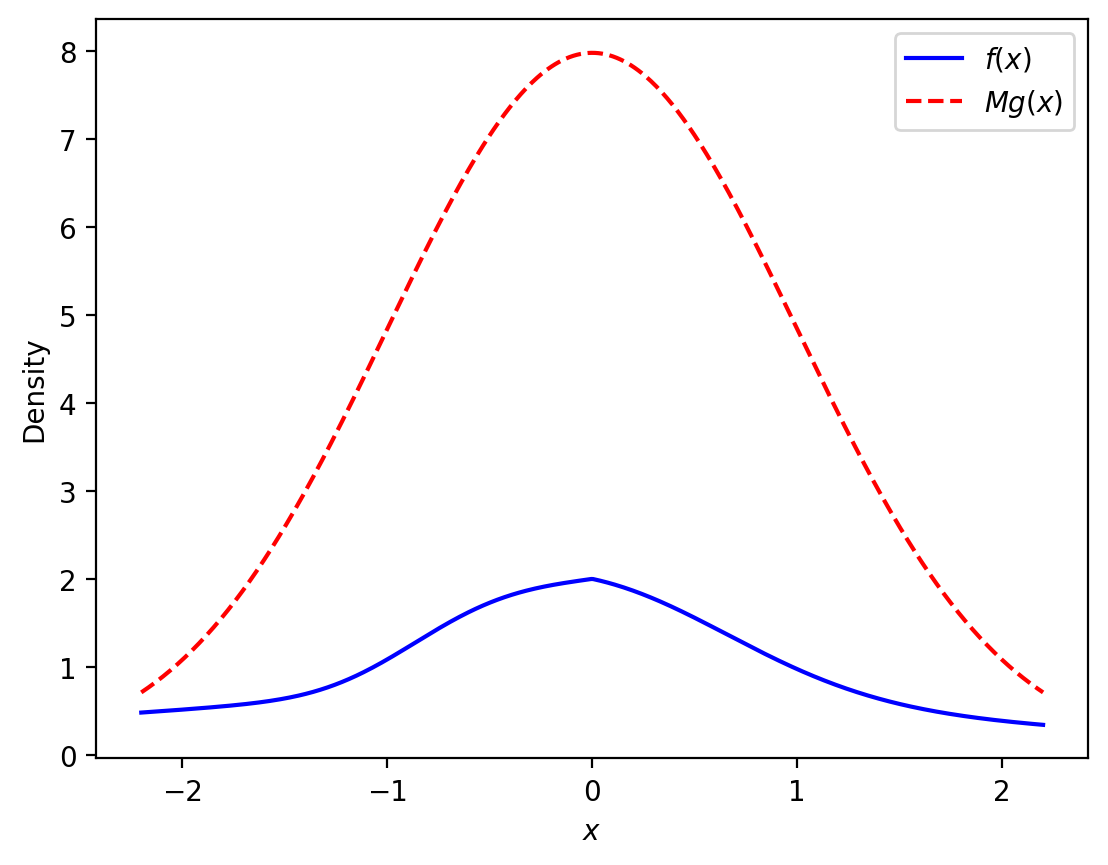

In [7]:
from scipy.stats import norm

# Define the target distribution f(x)
def f(x):
    return np.where(x >= 0, np.exp(-x/2) + np.exp(-x**2), np.exp(x/3) + np.exp(x**3))

# Define the proposal distribution g(x) as a normal distribution
mu_g = 0  # Mean of the normal distribution
sigma_g = 1  # Standard deviation of the normal distribution

def g(x):
    return norm.pdf(x, mu_g, sigma_g)

# Define the constant M such that M * g(x) >= f(x) for all x in the range -2.2 <= x <= 2.2
M = 20  # Set M to 20

# Generate x values
x = np.linspace(-2.2, 2.2, 500)

# Calculate f(x) and M * g(x)
fx = f(x)
Mgx = M * g(x)

# Plot f(x) and M * g(x)
plt.plot(x, fx, label='$f(x)$', color='blue')
plt.plot(x, Mgx, label='$Mg(x)$', color='red', linestyle='--')

# Add labels and legend
plt.xlabel('$x$')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

To simulate $Y$ with PDF $p$ that is proportional to $f$ perform the following steps.

__Step 1.__ Simulate a pseudo-random variable $X$ with PDF $g$ and an independent uniform pseudo-random variable $U$ on the interval $[0,1]$.<br>

__Step 2.__ If

$$\frac{f(X)}{Mg(X)} \geq U, $$

let $Y=X$, and stop the process.

__Step 3.__ If the condition in Step 2 is not satisfied, throw away $X$ and $U$, and return to Step 1.

If more than one $Y$ is needed, we repeat the entire process as many times as required.

It can be shown that the PDF of $Y$ in the accept-reject method is $p$. However, this proof is outside the scope of this class.

__Example__. Let us first find appropriate $g(x)$ and $M$ to simulate $Y$ with the following PDF $f(x)$:

$$
f(x) = \begin{cases}
3x^2 & \text{ if } 0 < x \leq 1,\\
0 & \text{ otherwise.}
\end{cases}
$$

Then we will implement the accept-reject method and use it to generate 100,000 observations.

A viable option for $g(x)$ is a continuous uniform distribution $g(x) = 1$ for $0 < x \leq 1$.

Next, we need to find $M$ such that:

   $$
   M g(x) \geq f(x) \quad \text{for all } x.
   $$

Since $f(x) = 3x^2$ reaches its maximum at $x = 1$, we have $f(1) = 3$. Thus, we can choose $M = 3.$

In [25]:
# Define the target PDF f(x)
def f(x):
    return 3 * x**2

# Define the proposal distribution g(x)
def g(x):
    return np.ones_like(x)

# Define the scaling factor M
M = 3

# Generate x values
x = np.linspace(0, 1, 500)

# Calculate f(x) and M*g(x)
f_x = f(x)
Mg_x = M * g(x)

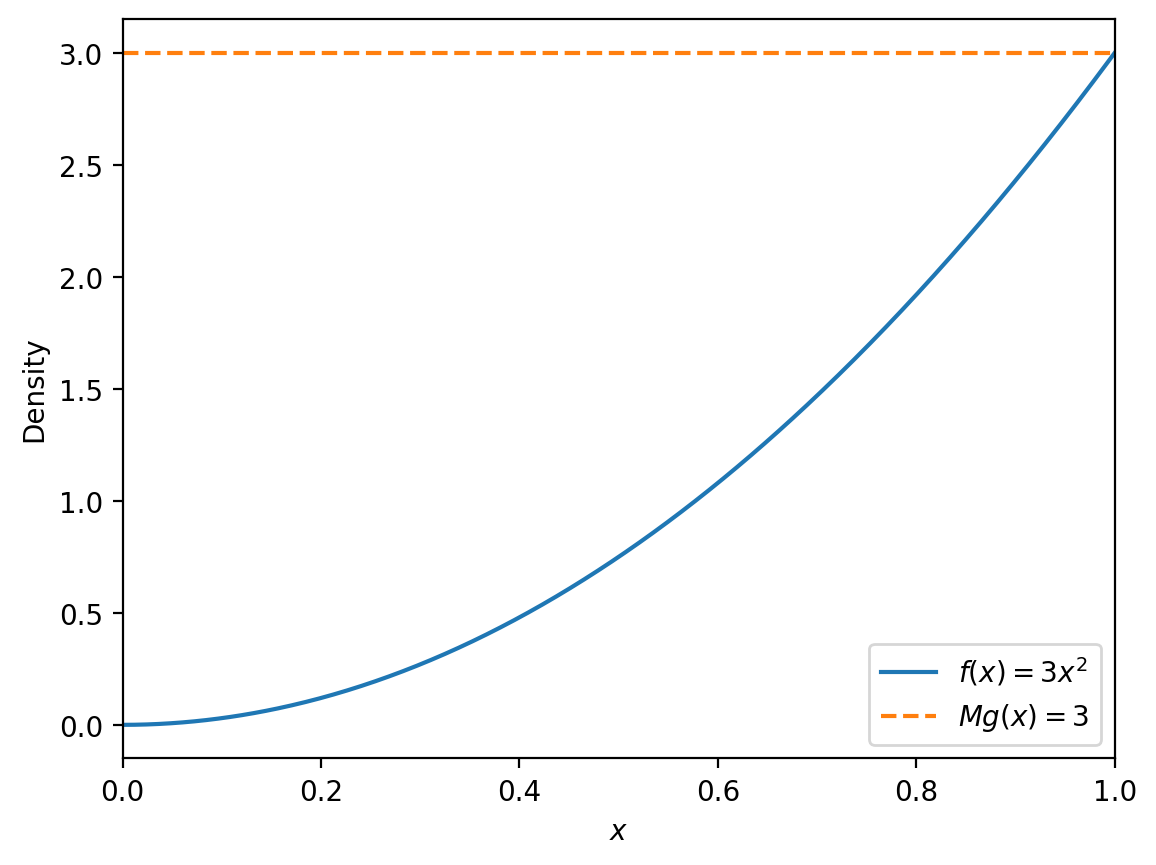

In [26]:
# Plot f(x) and M*g(x)
plt.plot(x, f_x, label='$f(x) = 3x^2$')
plt.plot(x, Mg_x, label='$Mg(x) = 3$', linestyle='--')
plt.xlim(0, 1)

# Visualize
plt.xlabel('$x$')
plt.ylabel('Density')
plt.legend()
plt.show()

Next, we are going to implement the accept-reject method and use it to generate 100,000 observations.

In [27]:
# Accept/reject algorithm
def accept_reject(n):
    observations = []
    while len(observations) < n:
        u = np.random.uniform(0, 1)
        x = np.random.uniform(0, 1)
        if f(x)/3 >= u:
            observations.append(x)
    return np.array(observations)

# Generate samples
n_observations = 100000
observations = accept_reject(n_observations)

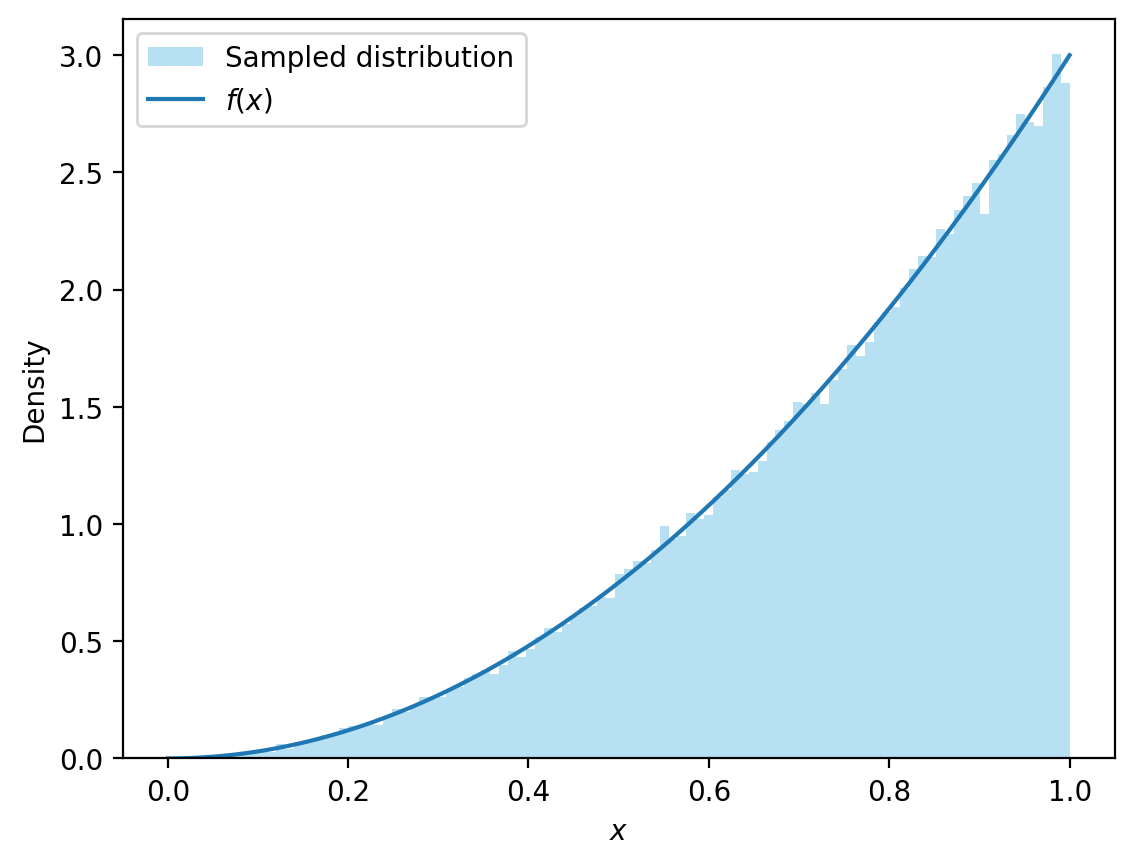

In [28]:
# Plot the histogram of the samples
plt.hist(observations, bins=100, density=True, alpha=0.6, color='skyblue', label='Sampled distribution')
plt.plot(x, f_x, label='$f(x)$')
plt.xlabel('$x$')
plt.ylabel('Density')
plt.legend()
plt.show()

One of the primary concerns with the acceptance-rejection method is its potentially low efficiency. The inefficiency becomes particularly pronounced when the proposal distribution $g(x)$ does not closely match the target distribution $p(x)$. A poor match can lead to a high rejection rate, meaning that many generated samples are discarded. Consequently, this high rejection rate can significantly slow down the overall sampling process.